In [1]:
# to handle datasets
import pandas as pd
import numpy as np

from glob import glob
import os

import matplotlib.pyplot as plt
%matplotlib inline
import cv2

# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

In [2]:
# data_preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# evaluate model and separate train and test
from sklearn.metrics import confusion_matrix

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# for the convolutional network
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing import image
from keras.utils import to_categorical

# Load Images / Data

In [5]:
# here are all our images
DATA_FOLDER = 'v2-plant-seedling-dataset'

In [6]:
# each wee class is in a dedicated folder
os.listdir(DATA_FOLDER)

['Cleavers',
 'Sugar beet',
 'Common Chickweed',
 'Loose Silky-bent',
 'Scentless Mayweed',
 'Shepherd’s Purse',
 'Fat Hen',
 'Common wheat',
 'Black-grass',
 'nonsegmentedv2',
 'Small-flowered Cranesbill',
 'Charlock',
 'Maize']

In [7]:
# Let's walk over the directory structure, so we understand
# how the images are stored

for class_folder_name in os.listdir(DATA_FOLDER):
    class_folder_path = os.path.join(DATA_FOLDER, class_folder_name)
    for image_path in glob(os.path.join(class_folder_path, '*.png')):
        print(image_path)

v2-plant-seedling-dataset/Cleavers/348.png
v2-plant-seedling-dataset/Cleavers/176.png
v2-plant-seedling-dataset/Cleavers/88.png
v2-plant-seedling-dataset/Cleavers/162.png
v2-plant-seedling-dataset/Cleavers/189.png
v2-plant-seedling-dataset/Cleavers/77.png
v2-plant-seedling-dataset/Cleavers/63.png
v2-plant-seedling-dataset/Cleavers/228.png
v2-plant-seedling-dataset/Cleavers/200.png
v2-plant-seedling-dataset/Cleavers/214.png
v2-plant-seedling-dataset/Cleavers/215.png
v2-plant-seedling-dataset/Cleavers/201.png
v2-plant-seedling-dataset/Cleavers/229.png
v2-plant-seedling-dataset/Cleavers/62.png
v2-plant-seedling-dataset/Cleavers/188.png
v2-plant-seedling-dataset/Cleavers/76.png
v2-plant-seedling-dataset/Cleavers/163.png
v2-plant-seedling-dataset/Cleavers/177.png
v2-plant-seedling-dataset/Cleavers/89.png
v2-plant-seedling-dataset/Cleavers/149.png
v2-plant-seedling-dataset/Cleavers/161.png
v2-plant-seedling-dataset/Cleavers/175.png
v2-plant-seedling-dataset/Cleavers/60.png
v2-plant-seedling-

In [8]:
# Let's creare a dataframe:
# the dataframe stores the path to the image in one column
# and the class of the weed (the target) in the next column

images_df = []

# navigate within each folder
for class_folder_name in os.listdir(DATA_FOLDER):
    class_folder_path = os.path.join(DATA_FOLDER, class_folder_name)

    # collect everry image path
    for image_path in glob(os.path.join(class_folder_path, '*.png')):
        tmp = pd.DataFrame([image_path, class_folder_name]).T
        images_df.append(tmp)

# concatenate the final df
images_df = pd.concat(images_df, axis=0, ignore_index=True)
images_df.columns = ['image', 'target']
images_df.head(10)

,image,target
0,v2-plant-seedling-dataset/Cleavers/348.png,Cleavers
1,v2-plant-seedling-dataset/Cleavers/176.png,Cleavers
2,v2-plant-seedling-dataset/Cleavers/88.png,Cleavers
3,v2-plant-seedling-dataset/Cleavers/162.png,Cleavers
4,v2-plant-seedling-dataset/Cleavers/189.png,Cleavers
5,v2-plant-seedling-dataset/Cleavers/77.png,Cleavers
6,v2-plant-seedling-dataset/Cleavers/63.png,Cleavers
7,v2-plant-seedling-dataset/Cleavers/228.png,Cleavers
8,v2-plant-seedling-dataset/Cleavers/200.png,Cleavers
9,v2-plant-seedling-dataset/Cleavers/214.png,Cleavers


In [9]:
# how many images do we've got per class?
# this should be give similar results to what we observerd
# when we inspected the length of image listin the dictionary

images_df['target'].value_counts()

target
Loose Silky-bent             762
Common Chickweed             713
Scentless Mayweed            607
Small-flowered Cranesbill    576
Fat Hen                      538
Sugar beet                   463
Charlock                     452
Cleavers                     335
Black-grass                  309
Shepherd’s Purse             274
Maize                        257
Common wheat                 253
Name: count, dtype: int64

In [10]:
# let's isolate a path, for demo
# we want to load the image in this path later

images_df.loc[0, 'image']

'v2-plant-seedling-dataset/Cleavers/348.png'

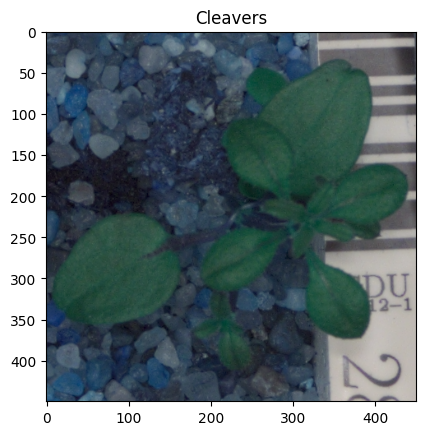

In [11]:
# Let's visualise a few images
# if the images you see in your notebook are not the same, don't

def plot_single_image(df, image_number):
    im = cv2.imread(df.loc[image_number, 'image'])
    plt.title(df.loc[image_number, 'target'])
    plt.imshow(im)

plot_single_image(images_df, 0)

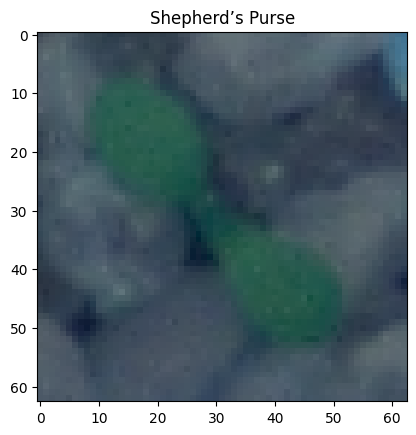

In [12]:
plot_single_image(images_df, 3000)

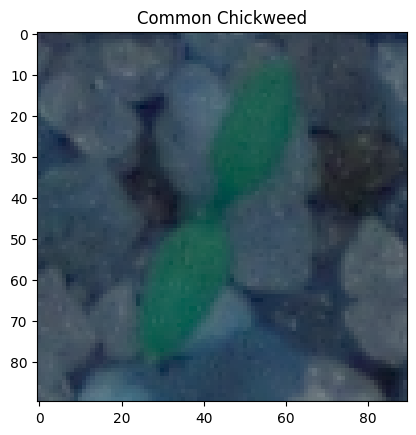

In [13]:
plot_single_image(images_df, 1000)

In [14]:
# Lot's go ahead and plot a bunch of imges together, 
# so we get a better filing of how out images look like

def plot_for_class(df, label):
    # function plots 9 images
    nb_rows = 3
    nb_cols = 3

    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 10))

    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            tmp = df[df['target'] == label]
            tmp.reset_index(drop=True, inplace=True)
            im = cv2.imread(tmp.loc[n, 'image'])
            axs[i, j].imshow(im)
            n += 1

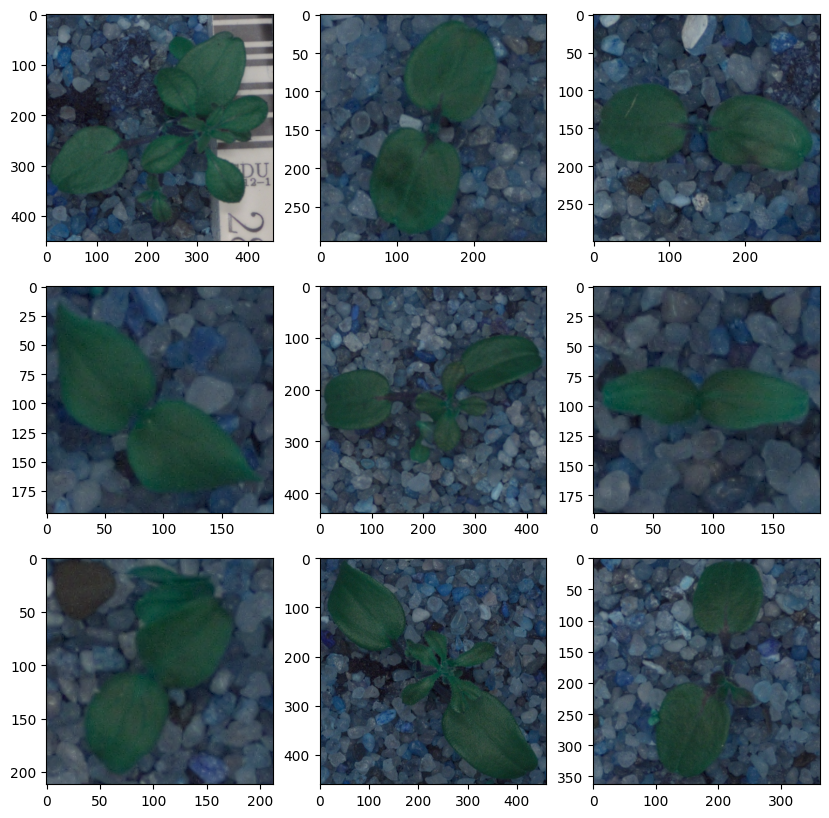

In [15]:
plot_for_class(images_df, 'Cleavers')

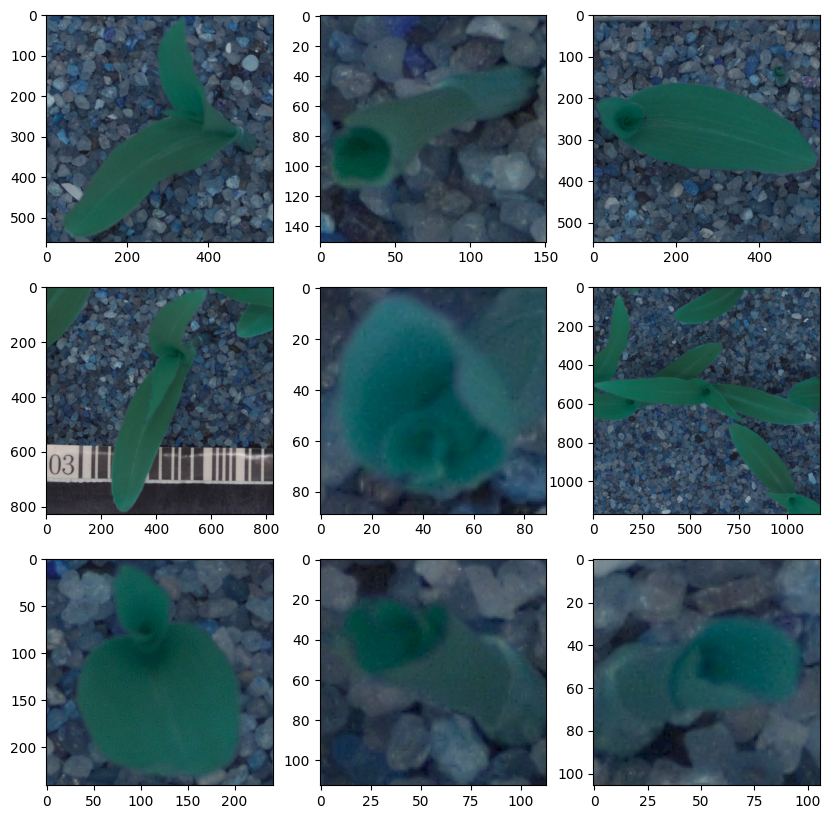

In [16]:
plot_for_class(images_df, 'Maize')

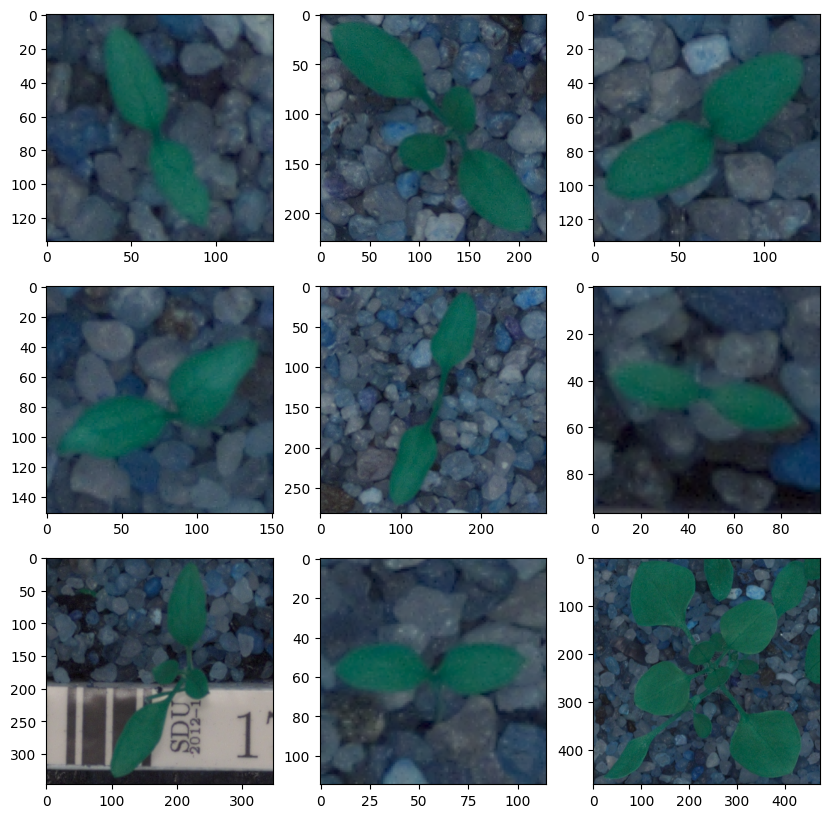

In [17]:
plot_for_class(images_df, 'Common Chickweed')

# Separate train and test

In [18]:
# train_test_split

X_train, X_test, y_train, y_test = train_test_split(images_df['image'], images_df['target'], 
                                                    test_size=.20, random_state=101)

print(X_train.shape)
print(X_test.shape)

(4431,)
(1108,)


In [19]:
# the indeces of the training data are mixed
# this will couse problems later

X_train.head()

1922    v2-plant-seedling-dataset/Loose Silky-bent/240...
4164        v2-plant-seedling-dataset/Black-grass/326.png
2952    v2-plant-seedling-dataset/Shepherd’s Purse/14.png
287             v2-plant-seedling-dataset/Cleavers/93.png
4971           v2-plant-seedling-dataset/Charlock/260.png
Name: image, dtype: object

In [20]:
# reset index, because later we iterate over row number

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
X_train.head()

0    v2-plant-seedling-dataset/Loose Silky-bent/240...
1        v2-plant-seedling-dataset/Black-grass/326.png
2    v2-plant-seedling-dataset/Shepherd’s Purse/14.png
3            v2-plant-seedling-dataset/Cleavers/93.png
4           v2-plant-seedling-dataset/Charlock/260.png
Name: image, dtype: object

In [21]:
# reset index in target as well

y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [22]:
# percentage of images within each class

y_train.value_counts() / len(y_train)

target
Loose Silky-bent             0.137666
Common Chickweed             0.128639
Scentless Mayweed            0.108328
Small-flowered Cranesbill    0.104717
Fat Hen                      0.095689
Sugar beet                   0.083277
Charlock                     0.081471
Cleavers                     0.060934
Black-grass                  0.057323
Shepherd’s Purse             0.048070
Common wheat                 0.047168
Maize                        0.046716
Name: count, dtype: float64

In [23]:
# should be the same in the test set

y_test.value_counts() / len(y_test)

target
Loose Silky-bent             0.137184
Common Chickweed             0.129061
Scentless Mayweed            0.114621
Fat Hen                      0.102888
Small-flowered Cranesbill    0.101083
Sugar beet                   0.084838
Charlock                     0.082130
Cleavers                     0.058664
Shepherd’s Purse             0.055054
Black-grass                  0.049639
Maize                        0.045126
Common wheat                 0.039711
Name: count, dtype: float64

In [24]:
# Let's prepare the target
# it is a multiclass classification, so we need to make
# one hot encoding of ther target

encoder = LabelEncoder()
encoder.fit(y_train)

train_y = to_categorical(encoder.transform(y_train))
test_y = to_categorical(encoder.transform(y_test))

train_y

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [25]:
# The images in our folders, are all different sizes
# For neural networks however, we need images in the same size
# The imges will all be resized to this size:

IMAGE_SIZE = 320

In [26]:
def im_resize(df, n):
    im = cv2.imread(df[n])
    im = cv2.resize(im, (IMAGE_SIZE, IMAGE_SIZE))
    return im

In [27]:
tmp = im_resize(X_train, 7)
tmp.shape

(320, 320, 3)

In [28]:
# the shape of the datasets needs to be (n1, n2, n3, n4)
# where n1 is the number of observations
# n2 and n3 are image width length
# and n4 indecates that it is a color image, so 3 planes per image

def create_dataset(df, image_size):
    # functions creates dataset as required for cnn
    tmp = np.zeros((len(df), image_size, image_size, 3), dtype='float32')

    for n in range(0, len(df)):
        im = im_resize(df, n)
        tmp[n] = im

    print(f'Dataset Images shape: {tmp.shape} size {tmp.size:,}')
    return tmp

In [29]:
x_train = create_dataset(X_train, IMAGE_SIZE)

Dataset Images shape: (4431, 320, 320, 3) size 1,361,203,200


In [30]:
x_test = create_dataset(X_test, IMAGE_SIZE)

Dataset Images shape: (1108, 320, 320, 3) size 340,377,600


In [31]:
# number of different classes

len(y_train.unique())

12

In [32]:
# this is our cnn

kernel_size = (3, 3)
pool_size = (2, 2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = .3
dropout_dense = .3

model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, activation='relu'))
# model.add(Conv2D(first_filters, kernel_size, activation='relu'))
model.add(MaxPool2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation='relu'))
model.add(Conv2D(second_filters, kernel_size, activation='relu'))
# model.add(Conv2D(second_filters, kernel_size, activation='relu'))
model.add(MaxPool2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation='relu'))
model.add(Conv2D(third_filters, kernel_size, activation='relu'))
# model.add(Conv2D(third_filters, kernel_size, activation='relu'))
model.add(MaxPool2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_dense))
model.add(Dense(12, activation='softmax'))

model.summary()

2025-06-29 10:25:47.247531: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-06-29 10:25:47.247558: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-06-29 10:25:47.247563: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-06-29 10:25:47.247580: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-29 10:25:47.247590: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 318, 318, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 316, 316, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 158, 158, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 158, 158, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 156, 156, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 154, 154, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 77, 77, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 77, 77, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 73, 73, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 165888)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    42,467,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,757,676 (163.11 MB)

 Trainable params: 42,757,676 (163.11 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model.compile(Adam(learning_rate=.0001), loss='binary_crossentropy', metrics=['accuracy']) 

In [34]:
batch_size = 10
epochs = 10

In [35]:
filepath = 'model.keras'
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1,
                            save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='acc', factor=.5, patience=1, verbose=1,
                             mode='max', min_lr=.00001)

callbacks_list = [checkpoint, reduce_lr]

history = model.fit(x=x_train, y=train_y, 
                   batch_size=batch_size,
                   validation_split=.1,
                   epochs=epochs,
                   verbose=2,
                   callbacks=callbacks_list)

Epoch 1/10


2025-06-29 10:25:51.177641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


399/399 - 32s - 80ms/step - accuracy: 0.1237 - loss: 2.1920 - val_accuracy: 0.1914 - val_loss: 0.3724 - learning_rate: 1.0000e-04
Epoch 2/10
399/399 - 29s - 73ms/step - accuracy: 0.1771 - loss: 2.3727 - val_accuracy: 0.3221 - val_loss: 0.2705 - learning_rate: 1.0000e-04
Epoch 3/10
399/399 - 31s - 76ms/step - accuracy: 0.2679 - loss: 2.2900 - val_accuracy: 0.5766 - val_loss: 0.7039 - learning_rate: 1.0000e-04
Epoch 4/10
399/399 - 30s - 76ms/step - accuracy: 0.3328 - loss: 6.4054 - val_accuracy: 0.5383 - val_loss: 4.7662 - learning_rate: 1.0000e-04
Epoch 5/10
399/399 - 30s - 74ms/step - accuracy: 0.3243 - loss: 152.8734 - val_accuracy: 0.5090 - val_loss: 32.7927 - learning_rate: 1.0000e-04
Epoch 6/10
399/399 - 32s - 79ms/step - accuracy: 0.3509 - loss: 1138.9994 - val_accuracy: 0.3086 - val_loss: 1449.7136 - learning_rate: 1.0000e-04
Epoch 7/10
399/399 - 34s - 85ms/step - accuracy: 0.2754 - loss: 6167.6499 - val_accuracy: 0.4505 - val_loss: 5819.4326 - learning_rate: 1.0000e-04
Epoch 8/1

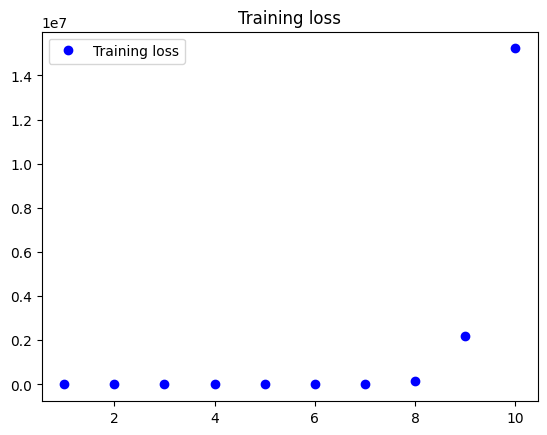

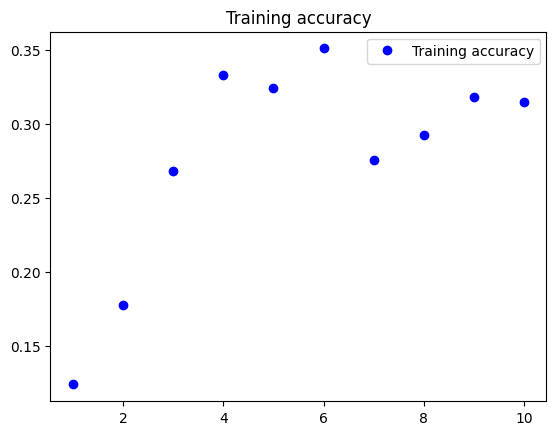

<Figure size 640x480 with 0 Axes>

In [36]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.figure();

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.title('Training accuracy')
plt.legend()
plt.figure();

In [37]:
# make a prediction

# predictions = model.predict(x_test, verbose=1)
# predictions = np.round(predictions)
# predictions = (model.predict(x_test) > 0.5).astype("int32")
predictions = np.argmax(model.predict(x_test),axis=1)

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


In [38]:
# inspect predictions

predictions

array([3, 3, 3, ..., 1, 3, 6])

In [39]:
# transform target

encoder.transform(y_test)

array([9, 2, 7, ..., 9, 3, 6])

In [40]:
cnf_matrix = confusion_matrix(encoder.transform(y_test), predictions)

In [41]:
# create a dict to map back the numbers into the classes

tmp = pd.concat([y_test, pd.Series(encoder.transform(y_test))], axis=1)
tmp.columns = ['class_name', 'class_number']
tmp.drop_duplicates(inplace=True)
tmp.reset_index(drop=True, inplace=True)
tmp = pd.Series(tmp.class_name.values, index=tmp.class_number).to_dict()
tmp = dict(sorted(tmp.items()))
tmp

{0: 'Black-grass',
 1: 'Charlock',
 2: 'Cleavers',
 3: 'Common Chickweed',
 4: 'Common wheat',
 5: 'Fat Hen',
 6: 'Loose Silky-bent',
 7: 'Maize',
 8: 'Scentless Mayweed',
 9: 'Shepherd’s Purse',
 10: 'Small-flowered Cranesbill',
 11: 'Sugar beet'}

In [42]:
# these we will display in the below matrix

abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']

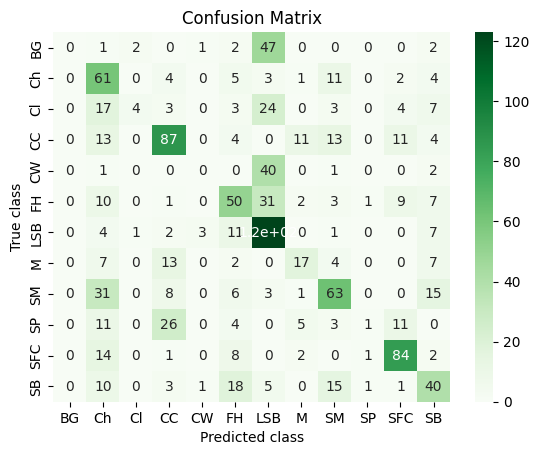

In [43]:
import seaborn as sns

fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(abbreviation)
ax.set_yticklabels(abbreviation)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
#fig.savefig('Confusion matrix.png', dpi=300)
plt.show();

In [44]:
from sklearn.metrics import accuracy_score

accuracy_score(encoder.transform(y_test), predictions, normalize=True, sample_weight=None)

0.47833935018050544

In [45]:
from sklearn.metrics import classification_report

print(classification_report(encoder.transform(y_test), predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        55
           1       0.34      0.67      0.45        91
           2       0.57      0.06      0.11        65
           3       0.59      0.61      0.60       143
           4       0.00      0.00      0.00        44
           5       0.44      0.44      0.44       114
           6       0.45      0.81      0.57       152
           7       0.44      0.34      0.38        50
           8       0.54      0.50      0.52       127
           9       0.25      0.02      0.03        61
          10       0.69      0.75      0.72       112
          11       0.41      0.43      0.42        94

    accuracy                           0.48      1108
   macro avg       0.39      0.38      0.35      1108
weighted avg       0.44      0.48      0.43      1108

